Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [3]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Do train/validate/test split with the Tanzania Waterpumps data.
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [117]:
# Begin with baselines for classification.
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [118]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [119]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
import numpy as np

# Define a function to wrangle train, validate, and test sets in the same way.

def wrangle(X):
    '''Wrangle train, validate, and test sets in the same way'''

    # Prevent SettingWithCopyWarning
    X = X.copy()

    # About 3% of the time, latitude has smaller values near zero,
    # outside of Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute the missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [15]:
# Select Features
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id', 'region_Manyara',
'region_Tabora',
'region_Mara',
'region_Dar es Salaam',
'recorded_by_GeoData Consultants Ltd',
'scheme_management_SWC',      
'scheme_management_Trust',
'scheme_management_None',
'extraction_type_other - swn 81',
'extraction_type_other - play pump',
'extraction_type_other - rope pump',
'extraction_type_climax',
'extraction_type_cemo',
'extraction_type_walimi',
'extraction_type_windmill',
'extraction_type_other - mkulima/shinyanga',
'extraction_type_group_other handpump',
'extraction_type_group_india mark iii',
'extraction_type_group_other motorpump',
'extraction_type_group_wind-powered',
'extraction_type_class_wind-powered',
'management_water authority',
'management_parastatal',
'management_unknown',
'management_company',
'management_other',
'management_trust',
'water_quality_fluoride',
'water_quality_unknown',
'water_quality_coloured',
'water_quality_fluoride abandoned',
'quality_group_fluoride',
'quality_group_milky',
'quality_group_colored',
'source_dam',
'source_other',
'source_unknown',
'source_type_dam',
'source_type_other',
'source_class_unknown',
'waterpoint_type_hand pump',
'waterpoint_type_improved spring',
'waterpoint_type_cattle trough',
'waterpoint_type_dam',
'waterpoint_type_group_hand pump',
'waterpoint_type_group_other',
'waterpoint_type_group_cattle trough',
'waterpoint_type_group_dam',
'region_Dodoma',
'source_lake',
'payment_type_other',
'payment_other',
'management_other - school',
'source_river',
'management_group_other',
'source_type_shallow well',
'water_quality_salty abandoned',
'region_Ruvuma',
'scheme_management_Parastatal',
'extraction_type_group_india mark ii',
'extraction_type_class_rope pump',
'scheme_management_Water Board',
'region_Lindi',
'management_wua',
'region_Kagera',
'management_water board',
'management_group_parastatal',
'source_machine dbh', 
'payment_pay when scheme fails',
'basin_Lake Nyasa',
'scheme_management_WUA',
'waterpoint_type_communal standpipe',
'source_hand dtw',
'management_group_unknown',
'extraction_type_other',
'extraction_type_afridev',
'payment_type_unknown',
'basin_Lake Tanganyika',
'extraction_type_mono',
'extraction_type_group_afridev',
'extraction_type_group_other',
'num_private',
'scheme_management_Private operator',
'payment_pay annually',
'region_Iringa',
'region_Kilimanjaro',
'region_Singida',
'payment_never pay',
'basin_Rufiji',
'source_shallow well',
'region_Pwani',
'region_Kigoma',
'management_group_commercial',
'management_wug',
'quality_group_good',
'water_quality_soft',
'extraction_type_group_rope pump',
'scheme_management_Other',
'basin_Lake Victoria',
'water_quality_salty',
'extraction_type_india mark iii',
'extraction_type_class_submersible',
'region_Mtwara',
'payment_pay monthly',
'extraction_type_group_swn',
'region_Mwanza',
'management_group_user-group',
'basin_Ruvuma / Southern Coast',
'scheme_management_WUG',
'source_class_surface',
'waterpoint_type_group_improved spring',
'extraction_type_india mark ii',
'payment_type_annually',
'quality_group_salty',
'source_rainwater harvesting',
'region_Arusha',
'extraction_type_submersible',
'region_Mbeya',
'scheme_management_Water authority',
'basin_Pangani',
'source_type_rainwater harvesting',
'waterpoint_type_group_communal standpipe',
'quantity_seasonal',
'extraction_type_swn',
'basin_Wami / Ruvu',
'scheme_management_Company',
'scheme_management_VWC',
'quantity_unknown',
'extraction_type_class_gravity',
'payment_type_on failure',
'public_meeting_True',
'extraction_type_group_mono',
'extraction_type_group_nira/tanira',
'payment_pay per bucket',
'extraction_type_gravity'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [122]:
# Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)
# Get your validation accuracy score.
pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

y_pred = pipeline.predict(X_test)

Train accuracy: 0.9954755892255892
Validation accuracy: 0.7585858585858586


In [123]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=11)
)

pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

y_pred = pipeline.predict(X_test)

Train accuracy: 0.8323442760942761
Validation accuracy: 0.7702020202020202


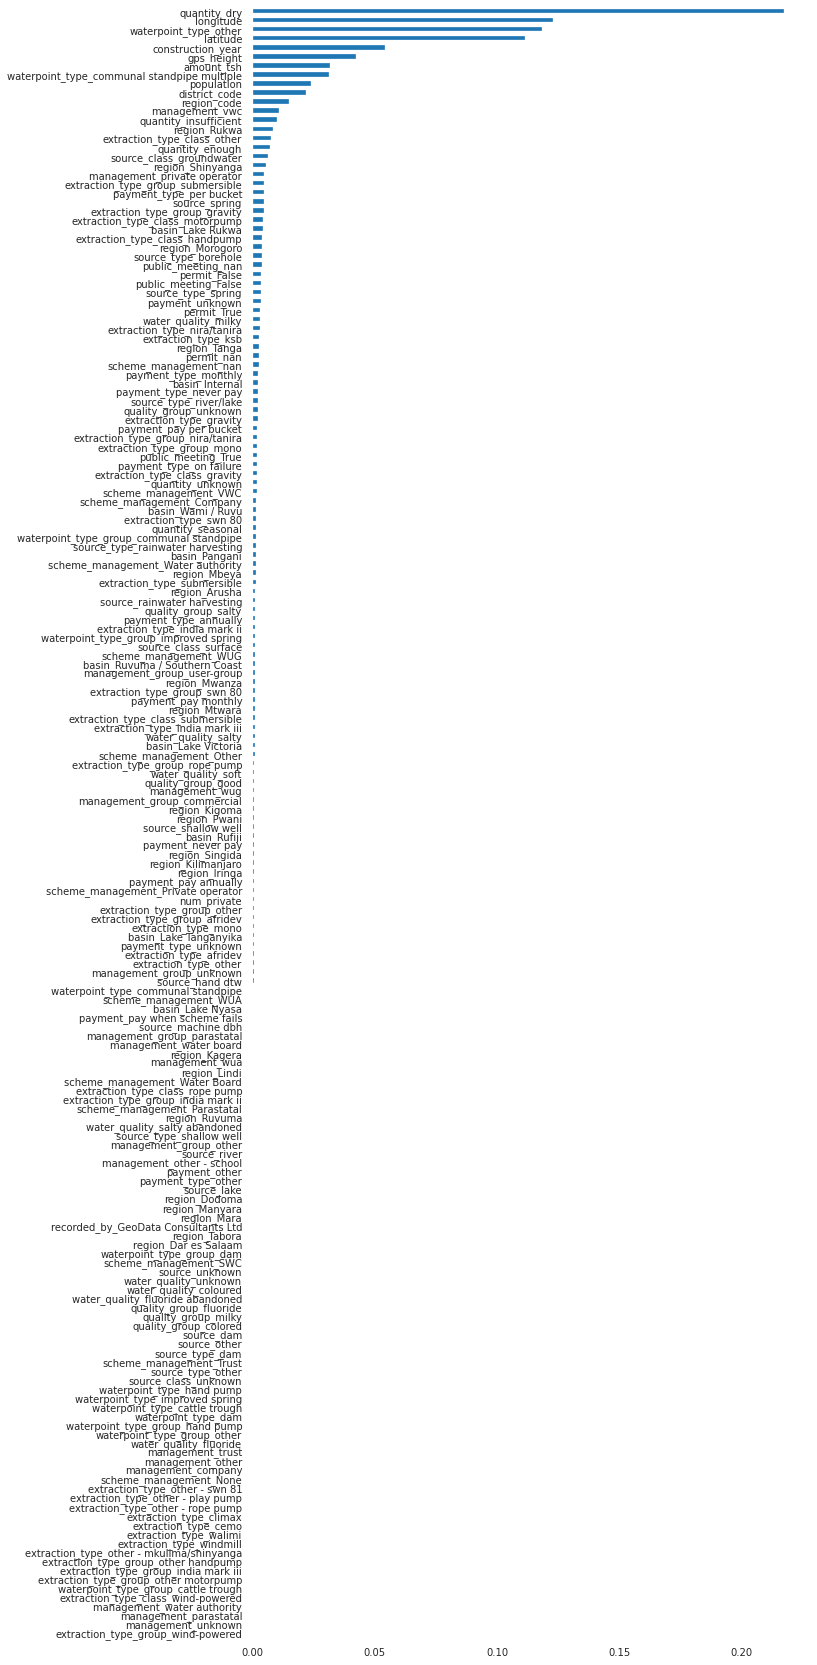

In [124]:
# Get and plot your feature importances.
import matplotlib.pyplot as plt
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 30))
importances.sort_values().plot.barh();

In [0]:
# I made a list of all of the "encoded_columns" that had 0 importances
# so that I could remove them from the model and compare accuracy. 
# I also trained the model with only the top 50% of importances. (no difference in accuracy)
# The model trained with only the top 25% of importances also did not improve accuracy
# Feature Engineering seems like it would offer the best improvement at this point.

In [97]:
importances.value_counts()

0.000000    48
0.003005     1
0.000427     1
0.000334     1
0.001370     1
            ..
0.000301     1
0.003674     1
0.004631     1
0.000900     1
0.002730     1
Length: 133, dtype: int64

In [98]:
importances.sort_values(ascending = False)

quantity_dry                          0.217503
longitude                             0.122840
waterpoint_type_other                 0.118539
latitude                              0.111398
construction_year                     0.054153
                                        ...   
extraction_type_class_wind-powered    0.000000
management_water authority            0.000000
management_parastatal                 0.000000
management_unknown                    0.000000
extraction_type_group_wind-powered    0.000000
Length: 180, dtype: float64

In [99]:
mostimportant50percent = importances.nlargest(90, keep='first')
mostimportant50percent

quantity_dry                   0.217503
longitude                      0.122840
waterpoint_type_other          0.118539
latitude                       0.111398
construction_year              0.054153
                                 ...   
quality_group_good             0.000697
management_wug                 0.000683
management_group_commercial    0.000656
region_Kigoma                  0.000620
region_Pwani                   0.000620
Length: 90, dtype: float64

In [105]:
leastmostimporttant50percent = mostimportant50percent.nsmallest(45, keep='first')
leastmostimporttant50percent

region_Pwani                                0.000620
region_Kigoma                               0.000620
management_group_commercial                 0.000656
management_wug                              0.000683
quality_group_good                          0.000697
water_quality_soft                          0.000705
extraction_type_group_rope pump             0.000717
scheme_management_Other                     0.000777
basin_Lake Victoria                         0.000778
water_quality_salty                         0.000784
extraction_type_india mark iii              0.000803
extraction_type_class_submersible           0.000809
region_Mtwara                               0.000810
payment_pay monthly                         0.000811
extraction_type_group_swn 80                0.000853
region_Mwanza                               0.000890
management_group_user-group                 0.000892
basin_Ruvuma / Southern Coast               0.000900
scheme_management_WUG                       0.

In [100]:
leastimportant50percent = importances.nsmallest(90, keep='first')
leastimportant50percent

region_Manyara                         0.000000
region_Tabora                          0.000000
region_Mara                            0.000000
region_Dar es Salaam                   0.000000
recorded_by_GeoData Consultants Ltd    0.000000
                                         ...   
region_Kilimanjaro                     0.000482
region_Singida                         0.000505
payment_never pay                      0.000515
basin_Rufiji                           0.000542
source_shallow well                    0.000592
Length: 90, dtype: float64

In [107]:
type(leastimportant50percent)

pandas.core.series.Series

In [82]:
print(leastimportant50percent.to_string())

region_Manyara                               0.000000
region_Tabora                                0.000000
region_Mara                                  0.000000
region_Dar es Salaam                         0.000000
recorded_by_GeoData Consultants Ltd          0.000000
scheme_management_SWC                        0.000000
scheme_management_Trust                      0.000000
scheme_management_None                       0.000000
extraction_type_other - swn 81               0.000000
extraction_type_other - play pump            0.000000
extraction_type_other - rope pump            0.000000
extraction_type_climax                       0.000000
extraction_type_cemo                         0.000000
extraction_type_walimi                       0.000000
extraction_type_windmill                     0.000000
extraction_type_other - mkulima/shinyanga    0.000000
extraction_type_group_other handpump         0.000000
extraction_type_group_india mark iii         0.000000
extraction_type_group_other 

In [87]:
leastimportant50percent.to_string()

'region_Manyara                               0.000000\nregion_Tabora                                0.000000\nregion_Mara                                  0.000000\nregion_Dar es Salaam                         0.000000\nrecorded_by_GeoData Consultants Ltd          0.000000\nscheme_management_SWC                        0.000000\nscheme_management_Trust                      0.000000\nscheme_management_None                       0.000000\nextraction_type_other - swn 81               0.000000\nextraction_type_other - play pump            0.000000\nextraction_type_other - rope pump            0.000000\nextraction_type_climax                       0.000000\nextraction_type_cemo                         0.000000\nextraction_type_walimi                       0.000000\nextraction_type_windmill                     0.000000\nextraction_type_other - mkulima/shinyanga    0.000000\nextraction_type_group_other handpump         0.000000\nextraction_type_group_india mark iii         0.000000\nextractio

In [0]:
leastimportant50percent
'region_Manyara',
'region_Tabora',
'region_Mara',
'region_Dar es Salaam',
'recorded_by_GeoData Consultants Ltd',
'scheme_management_SWC',      
'scheme_management_Trust',
'scheme_management_None',
'extraction_type_other - swn 81',
'extraction_type_other - play pump',
'extraction_type_other - rope pump',
'extraction_type_climax',
'extraction_type_cemo',
'extraction_type_walimi',
'extraction_type_windmill',
'extraction_type_other - mkulima/shinyanga',
'extraction_type_group_other handpump',
'extraction_type_group_india mark iii',
'extraction_type_group_other motorpump',
'extraction_type_group_wind-powered',
'extraction_type_class_wind-powered',
'management_water authority',
'management_parastatal',
'management_unknown',
'management_company',
'management_other',
'management_trust',
'water_quality_fluoride',
'water_quality_unknown',
'water_quality_coloured',
'water_quality_fluoride abandoned',
'quality_group_fluoride',
'quality_group_milky',
'quality_group_colored',
'source_dam',
'source_other',
'source_unknown',
'source_type_dam',
'source_type_other',
'source_class_unknown',
'waterpoint_type_hand pump',
'waterpoint_type_improved spring',
'waterpoint_type_cattle trough',
'waterpoint_type_dam',
'waterpoint_type_group_hand pump',
'waterpoint_type_group_other',
'waterpoint_type_group_cattle trough',
'waterpoint_type_group_dam',
'region_Dodoma',
'source_lake',
'payment_type_other',
'payment_other',
'management_other - school',
'source_river',
'management_group_other',
'source_type_shallow well',
'water_quality_salty abandoned',
'region_Ruvuma',
'scheme_management_Parastatal',
'extraction_type_group_india mark ii',
'extraction_type_class_rope pump',
'scheme_management_Water Board',
'region_Lindi',
'management_wua',
'region_Kagera',
'management_water board',
'management_group_parastatal',
'source_machine dbh', 
'payment_pay when scheme fails',
'basin_Lake Nyasa',
'scheme_management_WUA',
'waterpoint_type_communal standpipe',
'source_hand dtw',
'management_group_unknown',
'extraction_type_other',
'extraction_type_afridev',
'payment_type_unknown',
'basin_Lake Tanganyika',
'extraction_type_mono',
'extraction_type_group_afridev',
'extraction_type_group_other',
'num_private',
'scheme_management_Private operator',
'payment_pay annually',
'region_Iringa',
'region_Kilimanjaro',
'region_Singida',
'payment_never pay',
'basin_Rufiji',
'source_shallow well',

In [0]:
leastmostimportant50percent
'region_Pwani',
'region_Kigoma',
'management_group_commercial',
'management_wug',
'quality_group_good',
'water_quality_soft',
'extraction_type_group_rope pump',
'scheme_management_Other',
'basin_Lake Victoria',
'water_quality_salty',
'extraction_type_india mark iii',
'extraction_type_class_submersible',
'region_Mtwara',
'payment_pay monthly',
'extraction_type_group_swn',
'region_Mwanza',
'management_group_user-group',
'basin_Ruvuma / Southern Coast',
'scheme_management_WUG',
'source_class_surface',
'waterpoint_type_group_improved spring',
'extraction_type_india mark ii',
'payment_type_annually',
'quality_group_salty',
'source_rainwater harvesting',
'region_Arusha',
'extraction_type_submersible',
'region_Mbeya',
'scheme_management_Water authority',
'basin_Pangani',
'source_type_rainwater harvesting',
'waterpoint_type_group_communal standpipe',
'quantity_seasonal',
'extraction_type_swn',
'basin_Wami / Ruvu',
'scheme_management_Company',
'scheme_management_VWC',
'quantity_unknown',
'extraction_type_class_gravity',
'payment_type_on failure',
'public_meeting_True',
'extraction_type_group_mono',
'extraction_type_group_nira/tanira',
'payment_pay per bucket',
'extraction_type_gravity',

In [0]:
# Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass 
# competition webpage. Use the blue Submit Predictions button to upload your CSV file.
# Or you can use the Kaggle API to submit your predictions.)
 
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

#y_pred = estimator.predict(X_test)
y_pred = pipeline.predict(X_test)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Kagglewaterpumps1JohnDailey.csv', index=False)

from google.colab import files
files.download('Kagglewaterpumps1JohnDailey.csv')

In [0]:
# Commit your notebook to your fork of the GitHub repo.
